In [1]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-07-09T09:47:14.262 (PT)


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
using Turing: Variational
import Turing.RandomMeasures.DirichletProcess
import Turing.RandomMeasures.ChineseRestaurantProcess
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
import StatsBase.countmap
include(joinpath(@__DIR__, "../util/BnpUtil.jl"));

In [4]:
# Directory where all simulation data are stored.
data_dir = joinpath(@__DIR__, "../../data/sim-data")
path_to_data = joinpath(data_dir, "gmm-data-n50.json")
# path_to_data = joinpath(data_dir, "gmm-data-n200.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), path_to_data)
    JSON3.read(x, Dict{Symbol, Vector{Any}})
end

Dict{Symbol,Array{Any,1}} with 5 entries:
  :w        => Any[0.220078, 0.291918, 0.2498, 0.238204]
  :mu       => Any[-1.47027, -0.46176, 0.440237, 1.49896]
  :sig      => Any[0.148861, 0.121097, 0.195192, 0.19999]
  :y        => Any[-0.564699, -0.324993, -0.625064, -1.28564, -0.468499, -1.357…
  :rand_idx => Any[2, 2, 2, 1, 2, 1, 4, 4, 2, 4  …  2, 4, 3, 2, 1, 3, 4, 3, 2, …

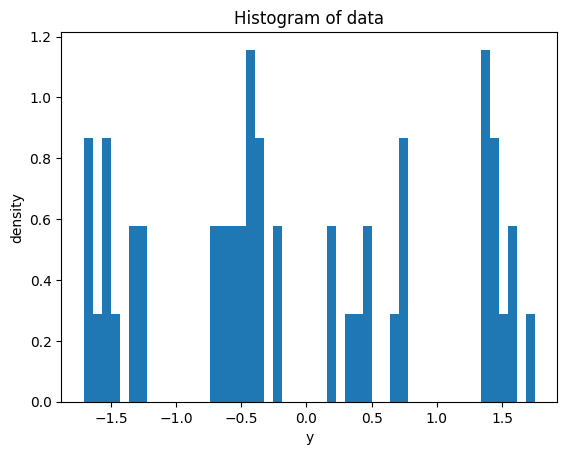

In [5]:
# Convert data to vector of floats
y = Float64.(data[:y]);

# Visualize data
plt.hist(y, bins=50, density=true)
plt.xlabel("y")
plt.ylabel("density")
plt.title("Histogram of data");

In [6]:
function counts_plot(x; density=false, color="C0", lw=4)
    cm_x = countmap(x)
    number = collect(keys(cm_x))
    count = let
        c = collect(values(cm_x))
        density ? c / sum(c) : c
    end
    plt.vlines(number, 0, count, color=color, lw=lw)
end

counts_plot (generic function with 1 method)

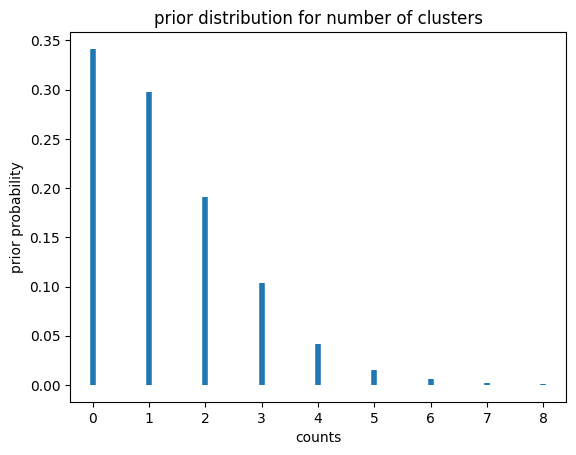

In [7]:
exp_num_clus(a, n) = a * log1p(n / a)

alpha_prior = Uniform(0, 0.5)
a = rand(alpha_prior, 10000)
nclus = rand.(Poisson.(exp_num_clus.(a, length(y))))

counts_plot(nclus, density=true)

plt.xlabel("counts")
plt.ylabel("prior probability")
plt.title("prior distribution for number of clusters");

# a = [0.1, 0.5, 1.0, 1.5, 2.0]
# plt.scatter(a, exp_num_clus.(a, 50))

In [96]:
@model function dp_gmm_crp_delayed(y, Kmax, ::Type{T}=Vector{Float64}) where T
    nobs = length(y)
    
    alpha ~ Gamma(1, 1/10)  # mean = a*b
    # alpha ~ Uniform(0, 1.0)
    rpm = DirichletProcess(alpha)
    
    # Base measure.
    H_mu = Normal(0, 3)
    H_sigma = Uniform(0, 0.3)
    # H_sigma = LogNormal(-1, 0.5)
    
    # Latent assignment.
    z = tzeros(Int, nobs)
    n = tzeros(Int, Kmax)
    K = 0

    mu = T(undef, Kmax)
    sigma = T(undef, Kmax)

    for i in 1:nobs
        z[i] ~ ChineseRestaurantProcess(rpm,  n)
        n[z[i]] += 1

        if z[i] > K
            mu[z[i]] ~ H_mu
            sigma[z[i]] ~ H_sigma
            K += 1
        end
        
        y[i] ~ Normal(mu[z[i]], sigma[z[i]])
    end
end;

In [176]:
# Set random seed for reproducibility
Random.seed!(0);

# Compile time approx. 32s.
# Run time approx. 70s

@time chain = begin
    burn = 3000  # NOTE: The burn in is also returned. Discard manually.
    n_samples = 1000
    iterations = burn + n_samples

    sample(dp_gmm_crp_delayed(y, 20), SMC(), iterations)
    
    # sample(dp_gmm_crp_delayed(y, 30), PG(10), iterations)
    # sample(dp_gmm_crp_delayed(y, 15), SMC(), iterations)
    # sample(dp_gmm_crp_delayed(y, 30), Gibbs(PG(20, :z), PG(10, :alpha, :mu, :sigma)), iterations)
    # sample(dp_gmm_crp_delayed(y, 15), Gibbs(PG(20, :z), PG(10, :mu, :sigma)), iterations)
    # sample(dp_gmm_crp_delayed(y, 30), Gibbs(MH(0.1, :alpha), PG(50, :z), MH(0.01, :mu, :sigma)), iterations)
    
    # sample(dp_gmm_crp_delayed(y, 30), Gibbs(MH(0.1, :alpha), PG(10, :z), HMC(0.01, 100, :mu, :sigma)), iterations)
    
    # NOTE: Works very poorly...
    # sample(dp_gmm_crp_delayed(y, 30), Gibbs(PG(5, :z), HMC(0.01, 10, :alpha, :mu, :sigma)), iterations)
    
    # sample(dp_gmm_crp(y), SMC(), iterations)
    # sample(dp_gmm_crp(y), IS(), iterations)
    # sample(dp_gmm_crp(y), Gibbs(PG(5, :z), PG(5, :mu_sigma)), iterations)
    # sample(dp_gmm_crp(y), PG(10), iterations)
end;

# TODO: Maybe try initializing at MAP?

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


 36.356043 seconds (127.10 M allocations: 9.743 GiB, 13.79% gc time)


In [177]:
burn=0
chain.value

3-dimensional AxisArray{Union{Missing, Float64},3,...} with axes:
    :iter, 1:1:4000
    :var, [:alpha, :le, :lp, Symbol("mu[1]"), Symbol("mu[2]"), Symbol("mu[3]"), Symbol("mu[4]"), Symbol("mu[5]"), Symbol("mu[6]"), Symbol("sigma[1]")  …  Symbol("z[41]"), Symbol("z[42]"), Symbol("z[43]"), Symbol("z[44]"), Symbol("z[45]"), Symbol("z[46]"), Symbol("z[47]"), Symbol("z[48]"), Symbol("z[49]"), Symbol("z[50]")]
    :chain, 1:1
And data, a 4000×66×1 Array{Union{Missing, Float64},3}:
[:, :, 1] =
 0.205672  -73.7392  0.0  -0.486002  …  1.0  2.0  4.0  3.0  4.0  1.0  3.0
 0.205672  -73.7392  0.0  -0.486002     1.0  2.0  4.0  3.0  4.0  1.0  3.0
 0.205672  -73.7392  0.0  -0.486002     1.0  2.0  4.0  3.0  4.0  1.0  3.0
 0.205672  -73.7392  0.0  -0.486002     1.0  2.0  4.0  3.0  4.0  1.0  3.0
 0.205672  -73.7392  0.0  -0.486002     1.0  2.0  4.0  3.0  4.0  1.0  3.0
 0.205672  -73.7392  0.0  -0.486002  …  1.0  2.0  4.0  3.0  4.0  1.0  3.0
 0.205672  -73.7392  0.0  -0.486002     1.0  2.0  4.0  3.0  4.

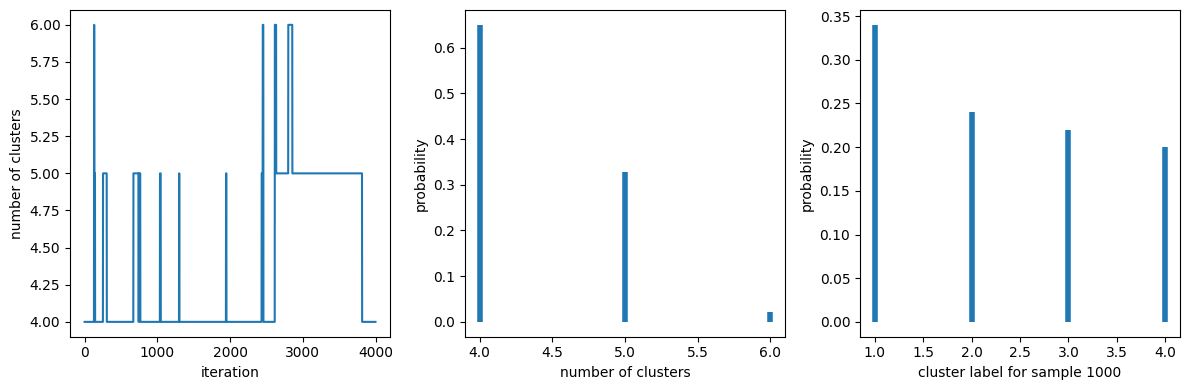

In [178]:
z = chain.value.data[burn+1:end, (end-length(y)+1):end, 1]
nclus = [length(unique(z[i, :])) for i in 1:size(z, 1)];

plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(nclus);
plt.xlabel("iteration")
plt.ylabel("number of clusters")

plt.subplot(1, 3, 2)
counts_plot(nclus, density=true);
plt.xlabel("number of clusters")
plt.ylabel("probability")

plt.subplot(1, 3, 3)
i = 1000
counts_plot(z[i, :], density=true);
plt.xlabel("cluster label for sample $(i)")
plt.ylabel("probability")

plt.tight_layout();

In [179]:
countmap(vec(Float64.(chain[:alpha].data)))

Dict{Float64,Int64} with 1 entry:
  0.205672 => 4000

In [180]:
function extract_vec(chain, sym)
    syms = filter(x -> x != nothing, match.(Regex("$(sym)\\[\\d+\\]"), String.(chain.name_map[1])))
    syms = map(x -> Symbol(x.match), syms)
    return chain[syms]
end

extract_vec (generic function with 2 methods)

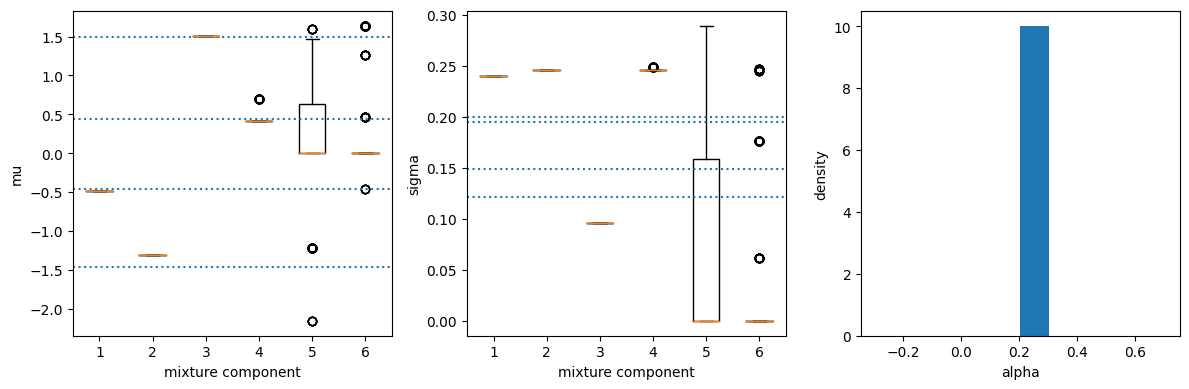

In [181]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
mu = coalesce.(extract_vec(chain, :mu).value.data[burn+1:end, :, 1], 0.0)
plt.boxplot(mu);
foreach(line -> plt.axhline(line, ls=":"), data[:mu])
plt.ylabel("mu")
plt.xlabel("mixture component")

plt.subplot(1, 3, 2)
sigma = coalesce.(extract_vec(chain, :sigma).value.data[burn+1:end, :, 1], 0.0)
plt.boxplot(coalesce.(sigma, 0.0));
foreach(line -> plt.axhline(line, ls=":"), data[:sig])
plt.ylabel("sigma")
plt.xlabel("mixture component")

plt.subplot(1, 3, 3)
plt.hist(Float64.(chain[:alpha].data[:, 1, 1]), density=true)
plt.xlabel("alpha")
plt.ylabel("density")

plt.tight_layout();

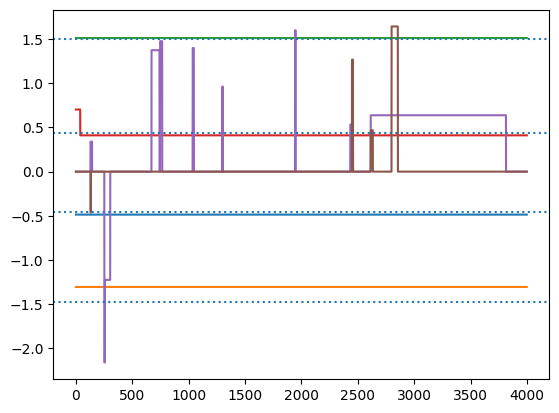

In [182]:
plt.plot(mu)
foreach(line -> plt.axhline(line, ls=":"), data[:mu])

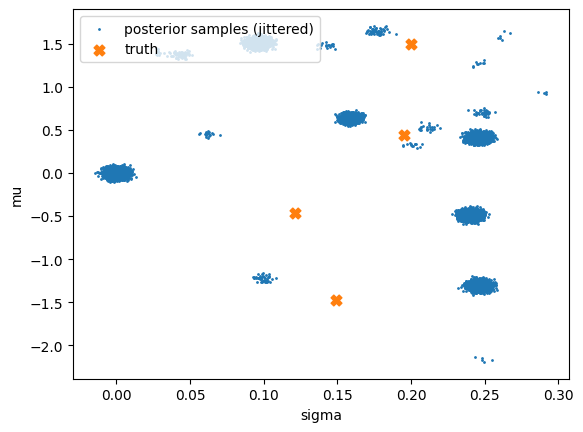

In [183]:
jitter(x; eps=std(x)/30) = x + randn(length(x)) * eps

plt.scatter(jitter(vec(sigma)), jitter(vec(mu)), label="posterior samples (jittered)", s=1);
plt.scatter(data[:sig], data[:mu], marker="X", s=60, label="truth")
plt.xlabel("sigma")
plt.ylabel("mu")
# foreach(line -> plt.axhline(line, ls=":"), data[:mu])
# foreach(line -> plt.axvline(line, ls=":"), data[:sig])
plt.legend(loc="upper left");